In [16]:
# !pip3 install opencv-python
# !apt-get update
# !DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends python3-opencv
# ! pip3 install numpy==1.19.5
# !pip3 freeze | grep numpy

numpy==1.19.5


In [5]:
import json
import sys

import PIL.Image
from IPython.display import Image, display
import numpy as np
import cv2
from matplotlib import pyplot as plt

from os.path import basename
from glob import glob


In [6]:
import os
classes = os.listdir('data')
# images = { c: ['data/' + c + '/' + f for f in os.listdir('data/' + c) if 'weird' in f] for c in classes }
images = { c: ['data/' + c + '/' + f for f in os.listdir('data/' + c) if 'weird' in f] for c in classes }

In [7]:
total, done = sum(len(paths) for paths in images.values()), 0

for paths in images.values():
    for path in paths:
        image = PIL.Image.open(path)
        image.thumbnail((400, 400), PIL.Image.ANTIALIAS)
        image.save(path.replace('data', 'resized'), "JPEG")
        done += 1
        if done % 100 == 0:
            print ('resized: {}/{}'.format(done, total))


resized: 100/241
resized: 200/241


In [8]:
import cv2
from os.path import basename
from glob import glob

def get_contours(img):
    # First make the image 1-bit and get contours
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    low_green = np.array([25, 52, 72])
    high_green = np.array([102, 255, 255])
    green_mask = cv2.inRange(hsv, low_green, high_green)
    green = cv2.bitwise_and(img, img, mask=green_mask)

    imgray = cv2.cvtColor(green, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgray, 150, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape[:2]
    return iw * ih

def contourOK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    if w < 50 or h < 50: return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape[:2]
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

def process_image(fname):
    img = cv2.imread(fname)
    contours = get_contours(img)
#     cv2.drawContours(img, contours, -1, (0,255,0)) # draws contours, good for debugging
    bounds = find_boundaries(img, contours)
    cropped = crop(img, bounds)
    return cropped


data/2.5/IMG20210623132457-weird.jpg


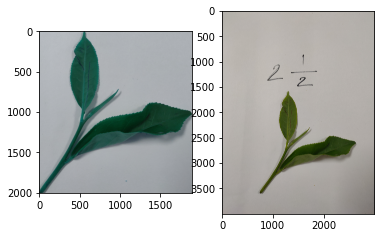

In [17]:
import PIL.Image
image = images['2.5'][13].replace('resized', 'data')
print(image)
_, x = plt.subplots(1, 2)
src = PIL.Image.open(image)
converted = process_image(image)
x[0].imshow(converted)
x[1].imshow(src)
plt.show()

In [54]:
import os
from pathlib import Path

# for p in Path("resized").glob("*/*.jpg"):
#     p.unlink()

classes = os.listdir('data')
images = { c: ['data/' + c + '/' + f for f in os.listdir('data/' + c)] for c in classes }

total, done = sum(len(paths) for paths in images.values()), 0

for paths in images.values():
    for path in paths:
        if done > 490:
            try:
                converted = None
                try:
                    converted = PIL.Image.fromarray(process_image(path))
                except Exception as e:
                    print(e)
                    cv2.imwrite('temp.jpg', process_image(path))
                    converted = PIL.Image.open('temp.jpg')
                converted.thumbnail((400, 400), PIL.Image.ANTIALIAS)
                converted.save(path.replace('data', 'resized'), "JPEG")
            except Exception as e:
                print ('Error with', path, '->', e)
        done += 1
        if done % 10 == 0:
            print ('resized: {}/{}: {}'.format(done, total, path.replace('data', 'resized')))


resized: 10/1806: resized/2.5/IMG20210726122932.jpg
resized: 20/1806: resized/2.5/IMG20210623132452-weird.jpg
resized: 30/1806: resized/2.5/IMG20210726122917.jpg
resized: 40/1806: resized/2.5/IMG20210801154636.jpg
resized: 50/1806: resized/2.5/IMG20210801154924.jpg
resized: 60/1806: resized/2.5/IMG20210819133404.jpg
resized: 70/1806: resized/2.5/IMG20210819132456.jpg
resized: 80/1806: resized/2.5/IMG20210726122602.jpg
resized: 90/1806: resized/2.5/IMG20210819132621.jpg
resized: 100/1806: resized/2.5/IMG20210819134851.jpg
resized: 110/1806: resized/2.5/IMG20210726122933.jpg
resized: 120/1806: resized/2.5/IMG20210819131724.jpg
resized: 130/1806: resized/2.5/IMG20210819132213.jpg
resized: 140/1806: resized/2.5/IMG20210726122953.jpg
resized: 150/1806: resized/2.5/IMG20210801155332.jpg
resized: 160/1806: resized/2.5/IMG20210819132748.jpg
resized: 170/1806: resized/2.5/IMG20210623132730_01-weird.jpg
resized: 180/1806: resized/2.5/IMG20210623132734-weird.jpg
resized: 190/1806: resized/2.5/IMG

In [58]:
import os
classes = os.listdir('resized')
images = { c: ['resized/' + c + '/' + f for f in os.listdir('resized/' + c)] for c in classes }
for c in images.keys():
    print (c, '->', len(images[c]))

2.5 -> 363
x -> 125
5.5 -> 103
1.5 -> 251
hb -> 193
3.5 -> 231
4.5 -> 335
sb -> 202


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/mobilenetv2_1.00_224/Conv1/Conv2D (defined at <ipython-input-30-44dfed7d1aac>:14) ]] [Op:__inference_predict_function_74214]

Function call stack:
predict_function


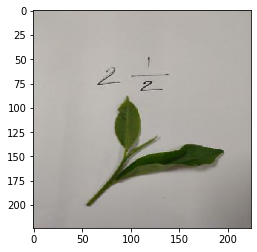

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
# model = load_model('model/checkpoint')

def convert_image(src):
    img = image.load_img(src, target_size=(224,224))
    plt.imshow(img)
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    # print(img)
    predictions = model.predict(img)
    print(predictions)




convert_image('resized/2.5/IMG20210623132457-weird.jpg')
